In [5]:
import numpy as np
import networkx as nx
import matplotlib as mpl
from datetime import datetime
import matplotlib.pyplot as plt
from itertools import combinations
from joblib import Parallel, delayed
from networkx.utils import py_random_state
import random, time, pickle, random, multiprocessing, matplotlib, copy, itertools

## Bulding the Network

In [6]:
def regular_clique(number_of_nodes, average_degree, clique_size):
    N, K, c = number_of_nodes, average_degree, clique_size
    if K % (c-1) != 0:
        raise Exception('This configuration is not possile')
    else:
        k = int(K/(c-1))
        m = int(N*k/c)
        nodes = [(u, _k) for u in range(N) for _k in range(k)]
        random.shuffle(nodes)
        cliques = [(u, _k) for u in range(m) for _k in range(c)]
        l = list(zip(cliques, nodes))
        my_list = [j[1][0] for j in l]
        node_collections = [my_list[i:i+c] for i in range(0, len(my_list), c)]
        g = nx.Graph()
        for col in node_collections:
            g.add_edges_from(itertools.combinations(col, 2))
        g.remove_edges_from(nx.selfloop_edges(g))
    return g

## Contact Tracing Process

In [7]:
def comp_g(g, compartment_name):
    '''
        returns nodes in compartment compartment_name
    '''
    return [node for node in g.nodes() if g.nodes()[node]['type'] == compartment_name]


def contact_tracing(G, alpha, p):
    '''
        returns number of nodes in different compartments S, I, Q, R
        after runing the SIR+Q process
    '''
    N = len(G)
    infection_seed = random.randint(0, N-1)
    compartments = dict([(infection_seed,{'type':'I'})] + [(node,{'type':'S'}) for node in G.nodes() if node != infection_seed])
    nx.set_node_attributes(G, compartments)
    
    new_seeds = {infection_seed} 
    while new_seeds:
        #check if there is no infection left
        t = [quarantine_infection(seed, G, alpha, p) for seed in new_seeds]
        new_seeds = {item for sublist in t for item in sublist}
    
    S, I, R, Q = comp_g(G, 'S'), comp_g(G, 'I'), comp_g(G, 'R'), comp_g(G, 'Q')

    return [len(S)/N, len(I)/N, len(R)/N, len(Q)/N, len(R)/N + p* len(Q)/N]


def quarantine_infection(infected_node, G, alpha, p):
    '''
        begins from new ifected nodes, yields new infected nodes
        while putting nodes in the right compartment
    '''
    new_infected_nodes = []
    for ne in G[infected_node]:
        if G.nodes()[ne]['type'] == 'S':
            if random.random() <= alpha:
                G.nodes()[ne]['type'] = 'Q'
            else:
                if random.random() <= p:
                    G.nodes()[ne]['type'] = 'I'
                    new_infected_nodes.append(ne)
    G.nodes()[infected_node]['type'] = 'R'
    
    return new_infected_nodes

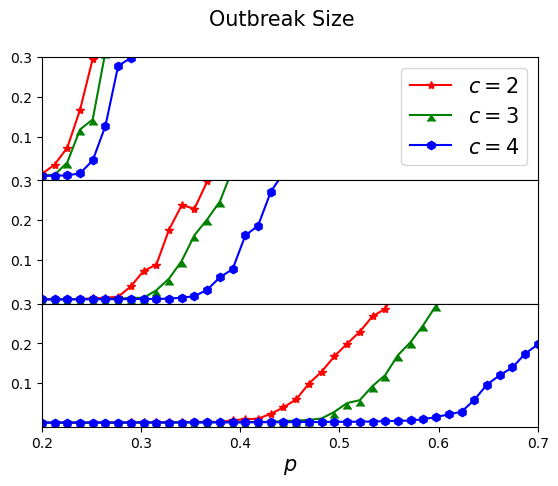

In [8]:
average_degree = 6 
c_1_list = [2,3,4]

p_range = np.linspace(0.2,0.70, 40)
alphas =  [0 , .25, 0.5]

ens = 10**2 #ensembel size
N = 10**4 

fig = plt.figure()
gs = fig.add_gridspec(3, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)
Gs = [regular_clique(N, average_degree, c) for c in c_1_list]

for _al in range(len(alphas)):
    CT = lambda p_range, G, alpha: [contact_tracing(G, alpha, p)[4] for p in p_range]
    data = [np.mean(np.array(Parallel(n_jobs = max(12, multiprocessing.cpu_count()))(delayed(CT)(p_range, G, alphas[_al]) for en in range(ens))), axis = 0) for G in Gs]
    #np.save(str(N)+'_'+str(alphas[_al])+'fig3A', data)
    
    colors = ['r', 'g', 'b', 'm'] 
    axs[_al].plot(p_range, data[0], marker ='*', label = r'$c = 2$', color = colors[0])
    axs[_al].plot(p_range, data[1], marker = 6, label =r'$c = 3$', color = colors[1])
    axs[_al].plot(p_range, data[2], marker= 'h', label = r'$c = 4$', color = colors[2])
    if _al == 2:
        axs[_al].set_yticks([.1, .2, .3])
    else:
        axs[_al].set_yticks([0, .1, .2])
    axs[_al].set_ylim(-0.01, .3)
    axs[_al].set_xlim(0.2, .7)
    axs[_al].set_xlabel(r'$p$', fontsize = 15)

axs[0].legend(fontsize = 15)
fig.suptitle(r'Outbreak Size', fontsize = 15)
plt.savefig(str(N)+'_'+str(alphas)+'_fig3A.pdf')   

## Loading from data

Text(0.5, 0.98, 'Outbreak Size')

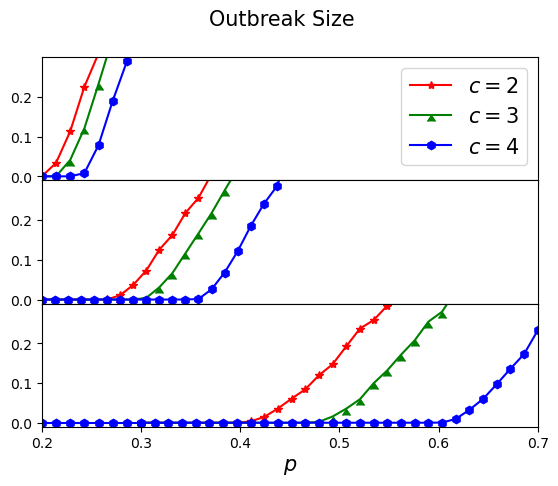

In [12]:
ens = 10**3
N = 2*10**6
average_degree = 6 
c_1_list = [2,3,4]
alphas =  [0   , .25, 0.5]

p_ranges = [np.linspace(0.1,0.30, 15), np.linspace(0.2,0.45, 20), np.linspace(0.3,0.7, 30)]

fig = plt.figure()
gs = fig.add_gridspec(3, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)

for _al in range(len(alphas)):
    data = np.load(str(N)+'_'+str(alphas[_al])+'_regular.npy')
    
    colors = ['r', 'g', 'b', 'm'] 
    axs[_al].plot(p_ranges[_al], data[0], marker ='*', label = r'$c = 2$', color = colors[0])
    axs[_al].plot(p_ranges[_al], data[1], marker = 6, label =r'$c = 3$', color = colors[1])
    axs[_al].plot(p_ranges[_al], data[2], marker= 'h', label = r'$c = 4$', color = colors[2])
    if _al == 2:
        axs[_al].plot(p_ranges[0], [0 for _ in p_ranges[0]], marker= 'h', label = r'$c = 4$', color = colors[2])

    axs[_al].set_yticks([0, .1, 0.2])
    axs[_al].set_ylim(-0.01, .3)
    axs[_al].set_xlim(0.2, .7)
    axs[_al].set_xlabel(r'$p$', fontsize = 15)

axs[0].legend(fontsize = 15)
fig.suptitle(r'Outbreak Size', fontsize = 15)
#plt.savefig(str(N)+'_'+str(alphas)+'_friday.pdf')   